In [1]:
!pip install lifelines --quiet


  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 349.3/349.3 kB 6.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.7/115.7 kB 6.9 MB/s eta 0:00:00


In [2]:
from lifelines import KaplanMeierFitter,CoxPHFitter
from lifelines.statistics import logrank_test
import pandas as pd

import matplotlib.pyplot as plt

In [3]:
df = pd.read_csv('veteran.csv')
df.head()

,ID,TIME,Y,trt,celltype,karno,diagtime,age,priortherapy
0,1,0,0,standard,squamous,60,7,69,no
1,1,72,1,standard,squamous,60,7,69,no
2,2,0,0,standard,squamous,70,5,64,yes
3,2,411,1,standard,squamous,70,5,64,yes
4,3,0,0,standard,squamous,60,3,38,no


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 274 entries, 0 to 273
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   ID            274 non-null    int64 
 1   TIME          274 non-null    int64 
 2   Y             274 non-null    int64 
 3   trt           274 non-null    object
 4   celltype      274 non-null    object
 5   karno         274 non-null    int64 
 6   diagtime      274 non-null    int64 
 7   age           274 non-null    int64 
 8   priortherapy  274 non-null    object
dtypes: int64(6), object(3)
memory usage: 19.4+ KB


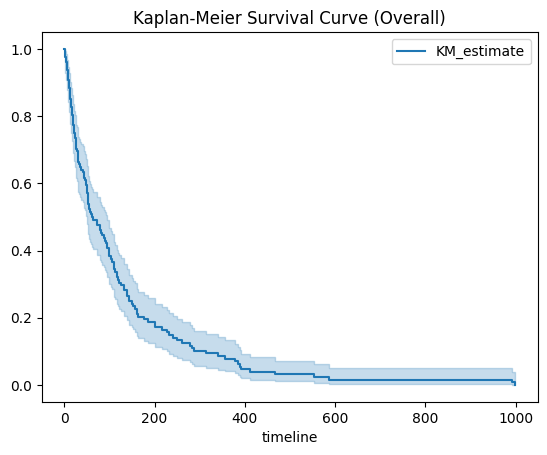

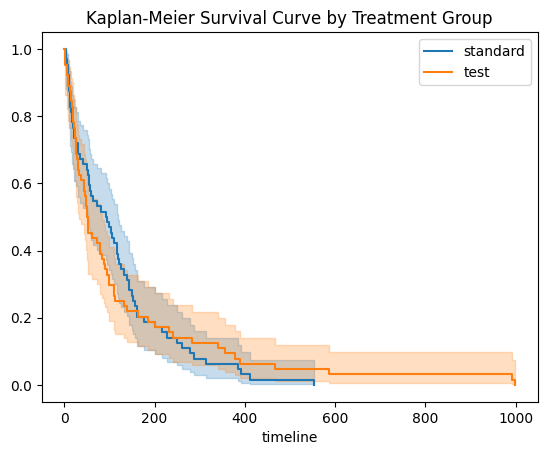

In [5]:
df_event = df[df['Y'] == 1]
kmf = KaplanMeierFitter()
# Example: overall KM curve

kmf.fit(durations=df_event['TIME'], event_observed=df_event['Y'])
kmf.plot_survival_function()
plt.title('Kaplan-Meier Survival Curve (Overall)')
plt.show()

# Example by treatment group
for trt_group in df_event['trt'].unique():
  mask = df_event['trt'] == trt_group
  kmf.fit(df_event[mask]['TIME'], df_event [mask] ['Y'], label=str(trt_group))
  kmf.plot_survival_function()
plt.title('Kaplan-Meier Survival Curve by Treatment Group')
plt.show()

In [6]:
#Median survival time

for trt_group in df_event['trt'].unique():
  mask= df_event['trt'] == trt_group
  kmf.fit(df_event[mask] ['TIME'], df_event[mask]['Y'], label=str(trt_group))
  print(f"Median survival for treatment {trt_group}: {kmf.median_survival_time_}")

Median survival for treatment standard: 95.0
Median survival for treatment test: 52.0


In [7]:
from lifelines.statistics import logrank_test

group1 = df_event[df_event['trt'] == 'standard']
group2 = df_event[df_event['trt'] == 'test']

results = logrank_test(group1['TIME'], group2['TIME'], event_observed_A=group1 ['Y'], event_observed_B=group2['Y'])
print(results.summary)

   test_statistic        p  -log2(p)
0          0.0116  0.91423  0.129371


<lifelines.CoxPHFitter: fitted with 128 total observations, 0 right-censored observations>
             duration col = 'TIME'
                event col = 'Y'
      baseline estimation = breslow
   number of observations = 128
number of events observed = 128
   partial log-likelihood = -465.21
         time fit was run = 2025-07-04 04:45:35 UTC

---
                    coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                           
ID                  0.00      1.00      0.01           -0.03            0.03                0.97                1.03
karno              -0.03      0.97      0.01           -0.05           -0.02                0.96                0.98
diagtime           -0.00      1.00      0.01           -0.02            0.01                0.98                1.01
age                -0.01      0.99      0.01           -0.03            0.00                0.97                1.00
trt_test            0.16      1.17      1.02           -1.84            2.16                0.16                8.63
celltype_large     -0.83      0.43      0.36           -1.53           -0.14                0.22                0.87
celltype_smallcell -0.12      0.88      0.38           -0.88            0.63                0.42                1.88
celltype_squamous  -0.97      0.38      0.66           -2.27            0.33                0.10                1.38
priortherapy_yes    0.18      1.20      0.24           -0.28            0.65                0.76                1.91

                    cmp to     z      p  -log2(p)
covariate                                        
ID                    0.00  0.20   0.84      0.25
karno                 0.00 -6.08 <0.005     29.60
diagtime              0.00 -0.47   0.63      0.66
age                   0.00 -1.54   0.12      3.02
trt_test              0.00  0.16   0.88      0.19
celltype_large        0.00 -2.34   0.02      5.71
celltype_smallcell    0.00 -0.32   0.75      0.42
celltype_squamous     0.00 -1.47   0.14      2.82
priortherapy_yes      0.00  0.79   0.43      1.21
---
Concordance = 0.74
Partial AIC = 948.43
log-likelihood ratio test = 62.38 on 9 df
-log2(p) of ll-ratio test = 31.00

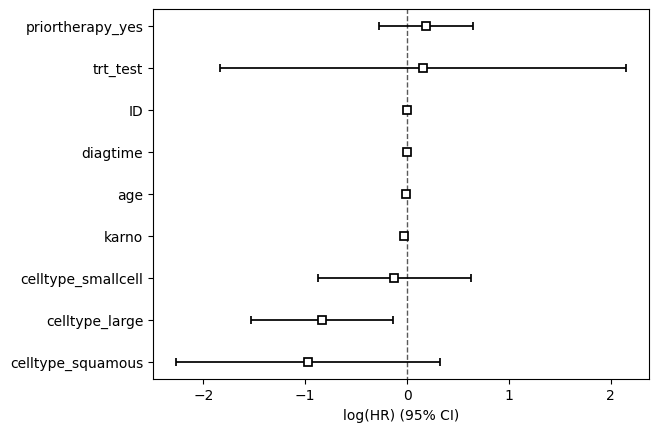

In [8]:
from lifelines import CoxPHFitter
#Prepare wide-format data: one row per subject
df_wide = df_event.copy()
#Encode categorical variables

df_wide = pd.get_dummies(df_wide, columns=['trt', 'celltype', 'priortherapy'], drop_first=True)
cph = CoxPHFitter()
cph.fit(df_wide, duration_col='TIME', event_col='Y')
cph.print_summary()
cph.plot()
plt.show()

In [9]:
# Step 1: Separate rows by Y
df_start = df[df["Y"] == 0].copy() # Start of observation/censoring
df_event = df[df["Y"] == 1].copy() # Death
#Step 2: Merge on ID
#Bring over TIME as stop and Y as event

df_event = df_event.rename(columns={"TIME": "stop", "Y": "event"})
df_start = df_start.rename(columns={"TIME": "start"})
df_timevarying = pd.merge(
  df_start,
  df_event[["ID", "stop", "event"]],
  on="ID"
)
#Step 3: One-hot encode categorical variables
df_timevarying = pd.get_dummies(df_timevarying, columns=["trt", "celltype", "priortherapy"], drop_first=True)
#Final check
print(df_timevarying [['ID', 'start', 'stop', 'event']].head())

   ID  start  stop  event
0   1      0    72      1
1   2      0   411      1
2   3      0   228      1
3   4      0   126      1
4   5      0   118      1


In [10]:
import numpy as np
#Check for NaNs
print("Any NaNs?", df_timevarying.isnull().values.any())
#Check for infinite values
print("Any Infs?", np.isinf(df_timevarying.select_dtypes (include=[np.number])).values.any())

Any NaNs? False
Any Infs? False


In [11]:
print(df_timevarying[df_timevarying.isnull().any(axis=1)])
print(df_timevarying[np.isinf(df_timevarying.select_dtypes (include=[np.number])).any(axis=1)])

Empty DataFrame
Columns: [ID, start, Y, karno, diagtime, age, stop, event, trt_test, celltype_large, celltype_smallcell, celltype_squamous, priortherapy_yes]
Index: []
Empty DataFrame
Columns: [ID, start, Y, karno, diagtime, age, stop, event, trt_test, celltype_large, celltype_smallcell, celltype_squamous, priortherapy_yes]
Index: []


In [12]:
# Ensure 'Y' is not in the modeling data
if 'Y' in df_timevarying.columns:
  df_timevarying.drop(columns=['Y'], inplace=True)

In [14]:
df_timevarying.head()

,ID,start,karno,diagtime,age,stop,event,trt_test,celltype_large,celltype_smallcell,celltype_squamous,priortherapy_yes
0,1,0,60,7,69,72,1,False,False,False,True,False
1,2,0,70,5,64,411,1,False,False,False,True,True
2,3,0,60,3,38,228,1,False,False,False,True,False
3,4,0,60,9,63,126,1,False,False,False,True,True
4,5,0,70,11,65,118,1,False,False,False,True,True


<lifelines.CoxTimeVaryingFitter: fitted with 128 periods, 128 subjects, 128 events>
         event col = 'event'
number of subjects = 128
 number of periods = 128
  number of events = 128
partial log-likelihood = -465.24
  time fit was run = 2025-07-04 05:21:15 UTC

---
                    coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                           
karno              -0.03      0.97      0.01           -0.05           -0.02                0.96                0.98
diagtime           -0.00      1.00      0.01           -0.02            0.01                0.98                1.01
age                -0.01      0.99      0.01           -0.03            0.00                0.97                1.00
trt_test            0.36      1.44      0.21           -0.05            0.77                0.95                2.17
celltype_large     -0.80      0.45      0.30           -1.38           -0.21                0.25                0.81
celltype_smallcell -0.18      0.84      0.28           -0.72            0.36                0.49                1.44
celltype_squamous  -1.10      0.33      0.30           -1.68           -0.51                0.19                0.60
priortherapy_yes    0.18      1.19      0.23           -0.28            0.63                0.76                1.88

                    cmp to     z      p  -log2(p)
covariate                                        
karno                 0.00 -6.07 <0.005     29.52
diagtime              0.00 -0.45   0.65      0.61
age                   0.00 -1.53   0.12      3.00
trt_test              0.00  1.72   0.08      3.56
celltype_large        0.00 -2.65   0.01      6.95
celltype_smallcell    0.00 -0.65   0.52      0.96
celltype_squamous     0.00 -3.66 <0.005     11.94
priortherapy_yes      0.00  0.76   0.45      1.17
---
Partial AIC = 946.47
log-likelihood ratio test = 62.34 on 8 df
-log2(p) of ll-ratio test = 32.53

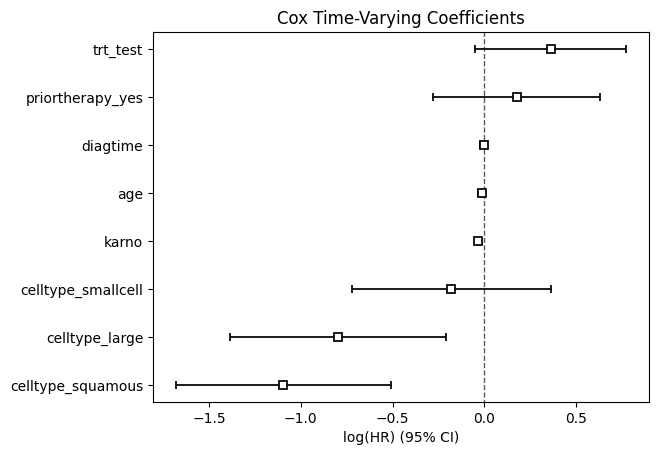

In [17]:
from lifelines import CoxTimeVaryingFitter

# Initialize the Cox time-varying model
ctv = CoxTimeVaryingFitter()
# Fit the model using the transformed dataframe
ctv.fit(
  df_timevarying,
  id_col='ID',
  start_col='start',
  stop_col='stop',
  event_col='event' # This reflects the renamed column
)
# Print model summary
ctv.print_summary()
# Plot coefficients
ctv.plot()
plt.title("Cox Time-Varying Coefficients")
plt.show()

In [18]:
print(df_timevarying.columns)

Index(['ID', 'start', 'karno', 'diagtime', 'age', 'stop', 'event', 'trt_test',
       'celltype_large', 'celltype_smallcell', 'celltype_squamous',
       'priortherapy_yes'],
      dtype='object')


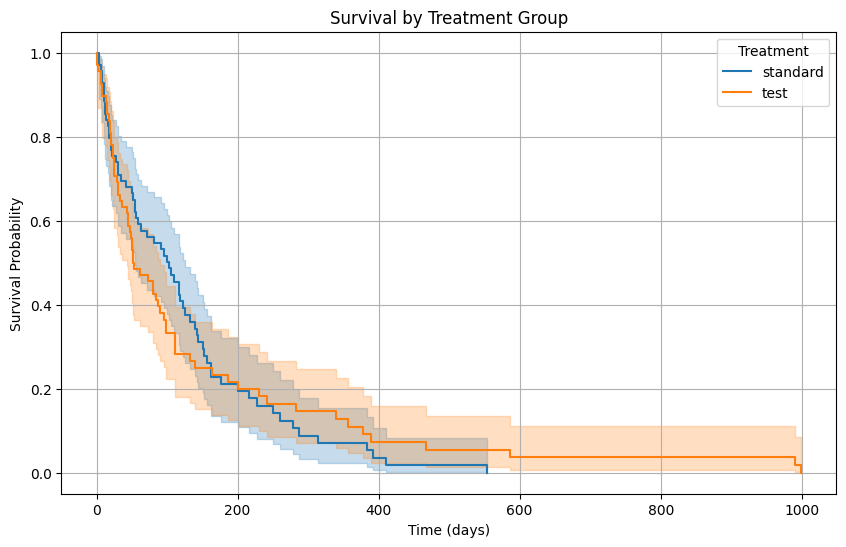

In [20]:
from lifelines import KaplanMeierFitter
import matplotlib.pyplot as plt

kmf = KaplanMeierFitter()
plt.figure(figsize=(10, 6))

for group in df['trt'].unique():
  label = str(group)
  mask = df['trt'] == group
  kmf.fit(df[mask] ['TIME'], event_observed=df[mask]['Y'], label=label)
  kmf.plot_survival_function()
plt.title('Survival by Treatment Group')
plt.xlabel('Time (days)')
plt.ylabel('Survival Probability')
plt.grid(True)
plt.legend(title="Treatment")
plt.show()

In [22]:
print(df['trt'].value_counts())

trt
standard    138
test        136
Name: count, dtype: int64


In [25]:
from lifelines.statistics import logrank_test
# Assuming 'trt' column has two treatment types (e.g., 1 = Standard, 2 = Test)

group1 = df[df['trt'] == 'standard']
group2 = df[df['trt'] == 'test']

# Perform the log-rank test using correct event column: 'Y'
results = logrank_test(
  group1 ['TIME'], group2['TIME'],
  event_observed_A=group1 ['Y'],
  event_observed_B=group2['Y']
)
# Output

print(f"Log-Rank Test p-value: {results.p_value:.4f}")
if results.p_value < 0.05:
  print("→ Significant difference in survival.")
else:
  print("→ No statistically significant difference.")

Log-Rank Test p-value: 0.9277
→ No statistically significant difference.


In [28]:
import pandas as pd
from lifelines import CoxPHFitter
#Encode categorical variables
df_encoded= pd.get_dummies(df, columns=['celltype', 'trt', 'priortherapy'], drop_first=True)
#Collect celltype dummy variables
celltype_dummies = [col for col in df_encoded.columns if col.startswith('celltype_')]
treatment_dummies = [col for col in df_encoded.columns if col.startswith('treatment_')]
prior_dummies = [col for col in df_encoded.columns if col.startswith('prior_')]

#Define final feature set

features = ['TIME', 'Y', 'age', 'karno', 'diagtime'] + celltype_dummies + treatment_dummies + prior_dummies

# Prepare dataset

cox_df = df_encoded [features]

#Fit Cox Proportional Hazards Model

cph = CoxPHFitter()

cph.fit(cox_df, duration_col='TIME', event_col='Y')

cph.print_summary()

<lifelines.CoxPHFitter: fitted with 274 total observations, 146 right-censored observations>
             duration col = 'TIME'
                event col = 'Y'
      baseline estimation = breslow
   number of observations = 274
number of events observed = 128
   partial log-likelihood = -475.48
         time fit was run = 2025-07-04 06:34:00 UTC

---
                    coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                           
age                -0.01      0.99      0.01           -0.02            0.01                0.98                1.01
karno              -0.03      0.97      0.01           -0.04           -0.02                0.96                0.98
diagtime            0.00      1.00      0.01           -0.01            0.02                0.99                1.02
celltype_large     -0.86      0.42      0.30           -1.44           -0.28                0.24                0.75
celltype_smallcell -0.46      0.63      0.26           -0.98            0.05                0.38                1.05
celltype_squamous  -1.18      0.31      0.30           -1.76           -0.60                0.17                0.55

                    cmp to     z      p  -log2(p)
covariate                                        
age                   0.00 -0.63   0.53      0.92
karno                 0.00 -5.86 <0.005     27.65
diagtime              0.00  0.37   0.71      0.49
celltype_large        0.00 -2.91 <0.005      8.13
celltype_smallcell    0.00 -1.78   0.07      3.74
celltype_squamous     0.00 -4.00 <0.005     13.97
---
Concordance = 0.74
Partial AIC = 962.96
log-likelihood ratio test = 59.94 on 6 df
-log2(p) of ll-ratio test = 34.33